<a href="https://colab.research.google.com/github/shah-zeb-naveed/autogen-udemy-course/blob/main/image_generator_critic_agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pyautogen[lmm] --upgrade -q

In [3]:
# snippets borrowed from https://microsoft.github.io/autogen/docs/notebooks/agentchat_image_generation_capability/
import os
import re
from typing import Dict, Optional

from IPython.display import display
from PIL.Image import Image

import autogen
from autogen import (
    Agent,
    AssistantAgent,
    ConversableAgent,
    GroupChat,
    GroupChatManager,
    UserProxyAgent
)
from autogen.agentchat.contrib import img_utils
from autogen.agentchat.contrib.capabilities import generate_images
from autogen.cache import Cache
from autogen.oai import openai_utils

from google.colab import userdata

In [4]:
# define configs for models

gpt_config = {
    "config_list": [{"model": "gpt-3.5-turbo", "api_key": userdata.get("OPENAI_API_KEY")}],
    "timeout": 120,
    "temperature": 0.5,
}

gpt_vision_config = {
    "config_list": [{"model": "gpt-4-vision-preview", "api_key": userdata.get("OPENAI_API_KEY")}],
    "timeout": 120,
    "temperature": 0.5,
}

dalle_config = {
    "config_list": [{"model": "dall-e-2", "api_key": userdata.get("OPENAI_API_KEY")}],
    "timeout": 120,
    "temperature": 0.5,
}

user_proxy (to agent_with_dalle_capability):

imagine kittens playing with a ball of yarn

--------------------------------------------------------------------------------
agent_with_dalle_capability (to user_proxy):

I generated an image with the prompt: Kittens playing with a ball of yarn.<image>

--------------------------------------------------------------------------------


ChatResult(chat_id=None, chat_history=[{'content': 'imagine kittens playing with a ball of yarn', 'role': 'assistant'}, {'content': [{'type': 'text', 'text': 'I generated an image with the prompt: Kittens playing with a ball of yarn.'}, {'type': 'image_url', 'image_url': {'url': ''}}], 'role': 'user'}], summary='I generated an image with the prompt: Kittens playing with a ball of yarn.', cost={'usage_including_cached_inference': {'total_cost': 0}, 'usage_excluding_cached_inference': {'total_cost': 0}}, human_input=[])
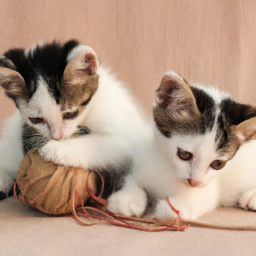

In [12]:
def _is_termination_message(msg) -> bool:
    if isinstance(msg.get("content"), str):
        return msg["content"].rstrip().endswith("TERMINATE")
    elif isinstance(msg.get("content"), list):
        for content in msg["content"]:
            print("this is content: ", content)
            if isinstance(content, dict) and "text" in content:
                return content["text"].rstrip().endswith("TERMINATE")
    return False


def get_image_generator_agent():
    # create agent
    agent = autogen.ConversableAgent(
        name="agent_with_dalle_capability",
        llm_config=gpt_vision_config,
        max_consecutive_auto_reply=2,
        human_input_mode="NEVER",
        is_termination_msg=lambda msg: _is_termination_message(msg),
    )

    # define image generation capability
    dalle_gen = generate_images.DalleImageGenerator(llm_config=dalle_config, resolution='256x256')
    image_gen_capability = generate_images.ImageGeneration(
        image_generator=dalle_gen,
        text_analyzer_llm_config=gpt_config,
        verbosity=2
    )

    # add ability
    image_gen_capability.add_to_agent(agent)
    return agent


user_proxy = UserProxyAgent(
    name="user_proxy",
    human_input_mode="NEVER",
    code_execution_config=False
)

image_generator_agent = get_image_generator_agent()
reply = user_proxy.initiate_chat(image_generator_agent, message='imagine kittens playing with a ball of yarn', max_turns=1)#.generate_reply('A dog')
reply

You might get errors like {'content': "Sorry, I can't generate images."}. This happens because of filtering on OpenAI's end which is too restrictive. You can try different/less controversial prompts

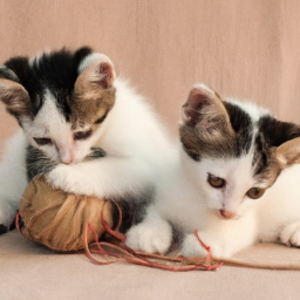

In [15]:
def extract_images(sender, recipient):
    images = []
    all_messages = sender.chat_messages[recipient]

    for message in reversed(all_messages):
        # The GPT-4V format, where the content is an array of data
        contents = message.get("content", [])
        for content in contents:
            if isinstance(content, str):
                continue
            if content.get("type", "") == "image_url":
                img_data = content["image_url"]["url"]
                images.append(img_utils.get_pil_image(img_data))

    if not images:
        raise ValueError("No image data found in messages.")

    return images

images = extract_images(image_generator_agent, user_proxy)
display(images[0])

You might get errors like {'content': "Sorry, I can't generate images."}. This happens because of filtering on OpenAI's end which is too restrictive. You can try different/less controversial prompts.

In [18]:
CRITIC_SYSTEM_MESSAGE = """You need to improve the prompt of the figures you saw.
How to create an image that is better in terms of color, shape, text (clarity), and other things.
Reply with the following format:

CRITICS: the image needs to improve...
PROMPT: here is the updated prompt!

If you have no critique or a prompt, just say TERMINATE
"""


def get_critic_agent():
    critic_agent = ConversableAgent(
        name="critic",
        llm_config=gpt_vision_config,
        system_message=CRITIC_SYSTEM_MESSAGE,
        max_consecutive_auto_reply=2,
        human_input_mode="NEVER",
        is_termination_msg=lambda msg: _is_termination_message(msg),
    )

    return critic_agent


image_generator_agent = get_image_generator_agent()
critic_agent = get_critic_agent()

prompt = "Create an image of two robots talking to each other"

result = critic_agent.initiate_chat(
    image_generator_agent,
    message=prompt
)

critic (to agent_with_dalle_capability):

Create an image of two robots talking to each other

--------------------------------------------------------------------------------
agent_with_dalle_capability (to critic):

I generated an image with the prompt: Two robots standing facing each other, with a futuristic and metallic look. They are engaged in conversation, with speech bubbles above their heads indicating communication. The setting is a high-tech environment with glowing panels and advanced technology in the background.<image>

--------------------------------------------------------------------------------
this is content:  {'type': 'text', 'text': 'I generated an image with the prompt: Two robots standing facing each other, with a futuristic and metallic look. They are engaged in conversation, with speech bubbles above their heads indicating communication. The setting is a high-tech environment with glowing panels and advanced technology in the background.'}
critic (to agent_wi

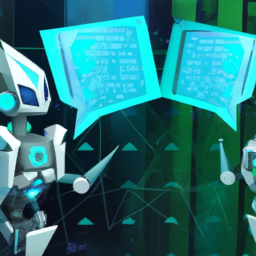

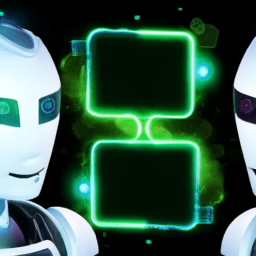

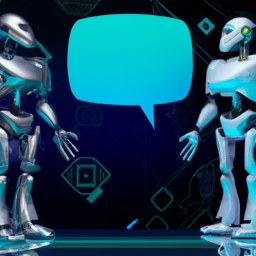

In [19]:
images = extract_images(image_generator_agent, critic_agent)

for image in images:
  display(image)